# Assignment 4 - Image Segmentation and CLIP Encoder
# Name - Pranav Gupta
# Roll No. - 2021101095

# 1. Image Segmentation using U-Net Architecture

**Context**

**Cityscapes data** contains labeled videos taken from vehicles driven in Germany. This version is a processed subsample created as part of the [Pix2Pix](https://phillipi.github.io/pix2pix/) paper. The dataset has still images from the original videos, and the semantic segmentation labels are shown in images alongside the original image. This is one of the best datasets around for semantic segmentation tasks.

**Content**

This dataset has 2975 training images files and 500 validation image files. Each image file is 256x512 pixels, and each file is a composite with the original photo on the left half of the image, alongside the labeled image (output of semantic segmentation) on the right half.

**Dataset:** 

https://www.kaggle.com/dansbecker/cityscapes-image-pairs

**References:** 

*   https://arxiv.org/pdf/1603.07285v1.pdf
*   https://towardsdatascience.com/u-net-b229b32b4a71



## 1.1 Preparation

### 1. Setup Libraries & device

In [1]:
import os
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

from tqdm.notebook import tqdm

In [2]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"

### 2. Configure data locations

In [3]:
data_dir = os.path.join("/kaggle", "input", "cityscapes-image-pairs", "cityscapes_data")
train_dir = os.path.join(data_dir, "train") 
val_dir = os.path.join(data_dir, "val")

train_fns = os.listdir(train_dir)
val_fns = os.listdir(val_dir)
print(len(train_fns), len(val_fns))

2975 500


### 3. Analyze data

/kaggle/input/cityscapes-image-pairs/cityscapes_data/train/1269.jpg


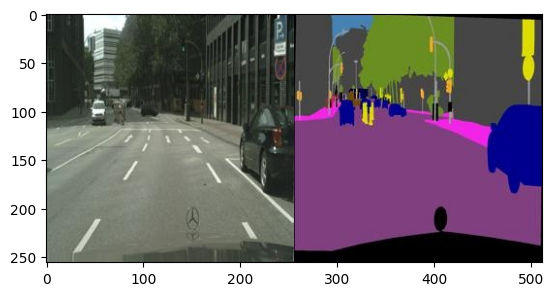

In [4]:
sample_image_fp = os.path.join(train_dir, train_fns[0])
sample_image = Image.open(sample_image_fp).convert("RGB")
plt.imshow(sample_image)
print(sample_image_fp)

### 4. Extract Image and Labels

The input images contain both the road scene and the corresponding label in the same image. Thus, we are splitting it and presenting it as two separate entities.

In [5]:
def split_image(image):
  image = np.array(image)
  cityscape, label = image[:, :256, :], image[:, 256:, :]
  return cityscape, label

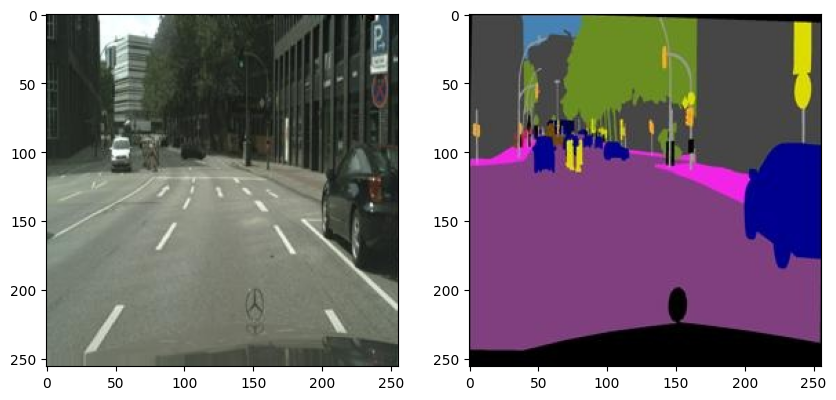

In [6]:
sample_image = np.array(sample_image)
cityscape, label = split_image(sample_image)

# display split images
cityscape, label = Image.fromarray(cityscape), Image.fromarray(label)
fig, axes = plt.subplots(1, 2, figsize=(10,5))
axes[0].imshow(cityscape)
axes[1].imshow(label)

### 5. Define Labels

We use K-means clustering to segregate the objects of different colors and assign them class labels.   

In [7]:
num_items = 1000
color_array = np.random.choice(range(256), 3*num_items).reshape(-1,3)
print(color_array.shape)

(1000, 3)


In [8]:
num_classes = 10
label_model = KMeans(n_clusters = num_classes)
label_model.fit(color_array)

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=10)

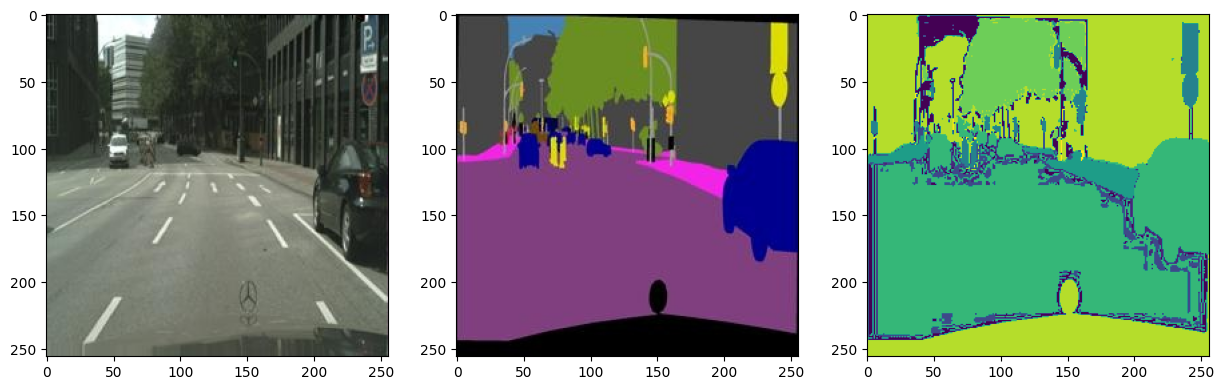

In [9]:
cityscape, label = split_image(sample_image)
label_class = label_model.predict(label.reshape(-1,3)).reshape(256,256)
fig, axes = plt.subplots(1,3,figsize=(15,5))
axes[0].imshow(cityscape)
axes[1].imshow(label)
axes[2].imshow(label_class)

### 6. Define Dataset

In [10]:
class CityscapeDataset(Dataset):

  def __init__(self, image_dir, label_model):
    self.image_dir = image_dir
    self.image_fns = os.listdir(image_dir)
    self.label_model = label_model

  def __len__(self):
    return len(self.image_fns)
  
  def __getitem__(self, index):
    image_fn = self.image_fns[index]
    image_fp = os.path.join(self.image_dir, image_fn)
    image = Image.open(image_fp).convert("RGB")
    image = np.array(image)
    cityscape, label = self.split_image(image)
    label_class = self.label_model.predict(label.reshape(-1,3)).reshape(256,256)
    label_class = torch.Tensor(label_class).long()
    cityscape = self.transform(cityscape)
    return cityscape, label_class

  def split_image(self, image):
    image = np.array(image)
    cityscape, label = image[:, :256, :], image[:, 256:, :]
    return cityscape, label
  
  def transform(self, image):
    transform_ops = transforms.Compose([
                                        transforms.ToTensor(),
                                        transforms.Normalize(mean=(0.485, 0.56, 0.406), std=(0.229, 0.224, 0.225))
    ])
    return transform_ops(image)

In [11]:
dataset = CityscapeDataset(train_dir, label_model)
print(len(dataset))

2975


In [12]:
cityscape, label_class = dataset[0]
print(cityscape.shape, label_class.shape)

torch.Size([3, 256, 256]) torch.Size([256, 256])


### 7. Define Model 


In [13]:
class UNet(nn.Module):
    
    def __init__(self, num_classes):
        super(UNet, self).__init__()
        self.num_classes = num_classes
        self.contracting_11 = self.conv_block(in_channels=3, out_channels=64)
        self.contracting_12 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.contracting_21 = self.conv_block(in_channels=64, out_channels=128)
        self.contracting_22 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.contracting_31 = self.conv_block(in_channels=128, out_channels=256)
        self.contracting_32 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.contracting_41 = self.conv_block(in_channels=256, out_channels=512)
        self.contracting_42 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.middle = self.conv_block(in_channels=512, out_channels=1024)
        self.expansive_11 = nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_12 = self.conv_block(in_channels=1024, out_channels=512)
        self.expansive_21 = nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_22 = self.conv_block(in_channels=512, out_channels=256)
        self.expansive_31 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_32 = self.conv_block(in_channels=256, out_channels=128)
        self.expansive_41 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_42 = self.conv_block(in_channels=128, out_channels=64)
        self.output = nn.Conv2d(in_channels=64, out_channels=num_classes, kernel_size=3, stride=1, padding=1)
        
    def conv_block(self, in_channels, out_channels):
        block = nn.Sequential(nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(num_features=out_channels),
                                    nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(num_features=out_channels))
        return block
    
    def forward(self, X):
        contracting_11_out = self.contracting_11(X) # [-1, 64, 256, 256]
        contracting_12_out = self.contracting_12(contracting_11_out) # [-1, 64, 128, 128]
        contracting_21_out = self.contracting_21(contracting_12_out) # [-1, 128, 128, 128]
        contracting_22_out = self.contracting_22(contracting_21_out) # [-1, 128, 64, 64]
        contracting_31_out = self.contracting_31(contracting_22_out) # [-1, 256, 64, 64]
        contracting_32_out = self.contracting_32(contracting_31_out) # [-1, 256, 32, 32]
        contracting_41_out = self.contracting_41(contracting_32_out) # [-1, 512, 32, 32]
        contracting_42_out = self.contracting_42(contracting_41_out) # [-1, 512, 16, 16]
        middle_out = self.middle(contracting_42_out) # [-1, 1024, 16, 16]
        expansive_11_out = self.expansive_11(middle_out) # [-1, 512, 32, 32]
        expansive_12_out = self.expansive_12(torch.cat((expansive_11_out, contracting_41_out), dim=1)) # [-1, 1024, 32, 32] -> [-1, 512, 32, 32]
        expansive_21_out = self.expansive_21(expansive_12_out) # [-1, 256, 64, 64]
        expansive_22_out = self.expansive_22(torch.cat((expansive_21_out, contracting_31_out), dim=1)) # [-1, 512, 64, 64] -> [-1, 256, 64, 64]
        expansive_31_out = self.expansive_31(expansive_22_out) # [-1, 128, 128, 128]
        expansive_32_out = self.expansive_32(torch.cat((expansive_31_out, contracting_21_out), dim=1)) # [-1, 256, 128, 128] -> [-1, 128, 128, 128]
        expansive_41_out = self.expansive_41(expansive_32_out) # [-1, 64, 256, 256]
        expansive_42_out = self.expansive_42(torch.cat((expansive_41_out, contracting_11_out), dim=1)) # [-1, 128, 256, 256] -> [-1, 64, 256, 256]
        output_out = self.output(expansive_42_out) # [-1, num_classes, 256, 256]
        return output_out

In [14]:
model = UNet(num_classes=num_classes).to(device)

In [15]:
data_loader = DataLoader(dataset, batch_size = 4)
print(len(dataset), len(data_loader))

2975 744


### 8. Train the model

In [16]:
batch_size = 16

epochs = 1
lr = 0.01

In [17]:
dataset = CityscapeDataset(train_dir, label_model)
data_loader = DataLoader(dataset, batch_size = batch_size)

In [18]:
model = UNet(num_classes = num_classes).to(device)

In [19]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = lr)

In [20]:
step_losses = []
epoch_losses = []

for epoch in tqdm(range(epochs)):
  epoch_loss = 0
  for X,Y in tqdm(data_loader, total=len(data_loader), leave = False):
    X, Y = X.to(device), Y.to(device)
    optimizer.zero_grad()
    Y_pred = model(X)
    loss = criterion(Y_pred, Y)
    loss.backward()
    optimizer.step()
    epoch_loss += loss.item()
    step_losses.append(loss.item())
  epoch_losses.append(epoch_loss/len(data_loader))

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/186 [00:00<?, ?it/s]

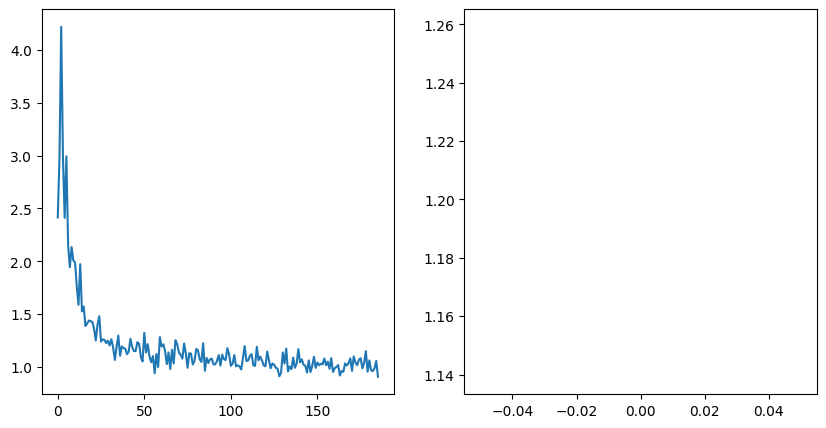

In [21]:
fig, axes = plt.subplots(1,2, figsize=(10,5))
axes[0].plot(step_losses)
axes[1].plot(epoch_losses)

In [22]:
model_name = "U-Net.pth"
torch.save(model.state_dict(), model_name)

### 9. Check model predictions

In [23]:
model_path = '/kaggle/working/U-Net.pth'
model_ = UNet(num_classes=num_classes).to(device)
model_.load_state_dict(torch.load(model_path))

/tmp/ipykernel_30/552489127.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_.load_state_dict(torch.load(model_path))


<All keys matched successfully>

In [24]:
test_batch_size = 10
dataset = CityscapeDataset(val_dir, label_model)
data_loader = DataLoader(dataset, batch_size=test_batch_size)

In [25]:
for X, Y in data_loader:
    X = X.to(device)
    Y = Y.to(device)
    Y_pred = model_(X)
    print(Y_pred.shape)
    Y_pred = torch.argmax(Y_pred, dim=1)
    print(Y_pred.shape)
    break

torch.Size([10, 10, 256, 256])
torch.Size([10, 256, 256])


In [26]:
inverse_transform = transforms.Compose([
    transforms.Normalize((-0.485/0.229, -0.456/0.224, -0.406/0.225), (1/0.229, 1/0.224, 1/0.225))
])

In [27]:
iou_scores = []

for i in range(test_batch_size):
    
    landscape = inverse_transform(X[i]).permute(1, 2, 0).cpu().detach().numpy()
    label_class = Y[i].cpu().detach().numpy()
    label_class_predicted = Y_pred[i].cpu().detach().numpy()
    
    # IOU score
    intersection = np.logical_and(label_class, label_class_predicted)
    union = np.logical_or(label_class, label_class_predicted)
    iou_score = np.sum(intersection) / np.sum(union)
    iou_scores.append(iou_score)
iou_scores

[0.9334241470556,
 0.9602448829287753,
 0.9300218340611354,
 0.9470759460174649,
 0.9598575293883853,
 0.9208470723821109,
 0.922264948753696,
 0.7188130001832732,
 0.9066719756249567,
 0.8780089534713048]

In [28]:
print(sum(iou_scores) / len(iou_scores))

0.9077230289866703


## 1.2 Importance of skip connections

### Define Model Architecture without Skip Connections 

In [31]:
class UNet(nn.Module):
    
    def __init__(self, num_classes):
        super(UNet, self).__init__()
        self.num_classes = num_classes
        self.contracting_11 = self.conv_block(in_channels=3, out_channels=32)
        self.contracting_12 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.contracting_21 = self.conv_block(in_channels=32, out_channels=64)
        self.contracting_22 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.contracting_31 = self.conv_block(in_channels=64, out_channels=128)
        self.contracting_32 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.contracting_41 = self.conv_block(in_channels=128, out_channels=256)
        self.contracting_42 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.middle = self.conv_block(in_channels=256, out_channels=512)
        self.expansive_11 = nn.ConvTranspose2d(in_channels=512, out_channels=512, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_12 = self.conv_block(in_channels=512, out_channels=256)
        self.expansive_21 = nn.ConvTranspose2d(in_channels=256, out_channels=256, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_22 = self.conv_block(in_channels=256, out_channels=128)
        self.expansive_31 = nn.ConvTranspose2d(in_channels=128, out_channels=128, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_32 = self.conv_block(in_channels=128, out_channels=64)
        self.expansive_41 = nn.ConvTranspose2d(in_channels=64, out_channels=64, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_42 = self.conv_block(in_channels=64, out_channels=32)
        self.output = nn.Conv2d(in_channels=32, out_channels=num_classes, kernel_size=3, stride=1, padding=1)
        
    def conv_block(self, in_channels, out_channels):
        block = nn.Sequential(nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
                            nn.ReLU(),
                            nn.BatchNorm2d(num_features=out_channels),
                            nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
                            nn.ReLU(),
                            nn.BatchNorm2d(num_features=out_channels)
                            )
        return block
    
    def forward(self, X):
        contracting_11_out = self.contracting_11(X) # [-1, 32, 256, 256]
        contracting_12_out = self.contracting_12(contracting_11_out) # [-1, 32, 128, 128]
        contracting_21_out = self.contracting_21(contracting_12_out) # [-1, 64, 128, 128]
        contracting_22_out = self.contracting_22(contracting_21_out) # [-1, 64, 64, 64]
        contracting_31_out = self.contracting_31(contracting_22_out) # [-1, 128, 64, 64]
        contracting_32_out = self.contracting_32(contracting_31_out) # [-1, 128, 32, 32]
        contracting_41_out = self.contracting_41(contracting_32_out) # [-1, 256, 32, 32]
        contracting_42_out = self.contracting_42(contracting_41_out) # [-1, 256, 16, 16]
        middle_out = self.middle(contracting_42_out) # [-1, 512, 16, 16]

        expansive_11_out = self.expansive_11(middle_out) # [-1, 512, 32, 32]
        expansive_12_out = self.expansive_12(expansive_11_out) # [-1, 512, 32, 32]
        expansive_21_out = self.expansive_21(expansive_12_out) # [-1, 256, 64, 64]
        expansive_22_out = self.expansive_22(expansive_21_out) # [-1, 128, 64, 64]
        expansive_31_out = self.expansive_31(expansive_22_out) # [-1, 128, 128, 128]
        expansive_32_out = self.expansive_32(expansive_31_out) # [-1, 64, 128, 128]
        expansive_41_out = self.expansive_41(expansive_32_out) # [-1, 64, 256, 256]
        expansive_42_out = self.expansive_42(expansive_41_out) # [-1, 32, 256, 256]
        output_out = self.output(expansive_42_out) # [-1, num_classes = 10, 256, 256]
        return output_out

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/186 [00:00<?, ?it/s]

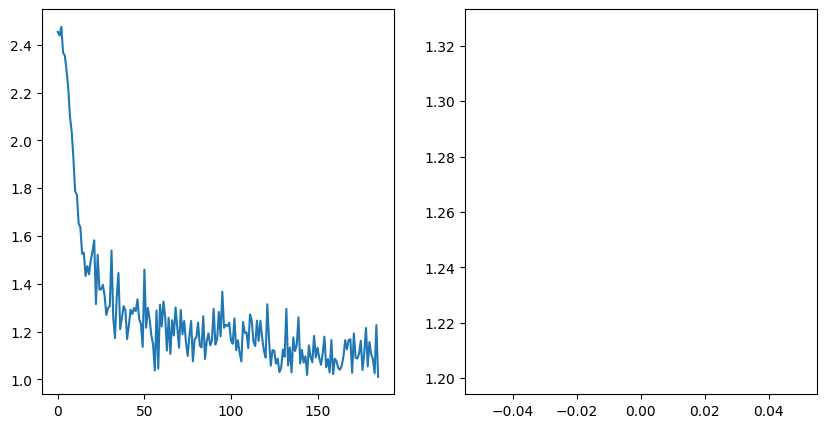

In [32]:
batch_size = 16

epochs = 1
lr = 0.01

dataset = CityscapeDataset(train_dir, label_model)
data_loader = DataLoader(dataset, batch_size = batch_size)
model = UNet(num_classes = num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = lr)

step_losses = []
epoch_losses = []

for epoch in tqdm(range(epochs)):
  epoch_loss = 0
  for X,Y in tqdm(data_loader, total=len(data_loader), leave = False):
    X, Y = X.to(device), Y.to(device)
    optimizer.zero_grad()
    Y_pred = model(X)
    loss = criterion(Y_pred, Y)
    loss.backward()
    optimizer.step()
    epoch_loss += loss.item()
    step_losses.append(loss.item())
  epoch_losses.append(epoch_loss/len(data_loader))

fig, axes = plt.subplots(1,2, figsize=(10,5))
axes[0].plot(step_losses)
axes[1].plot(epoch_losses)

model_name = "without-skip-connections-U-Net.pth"
torch.save(model.state_dict(), model_name)

In [33]:
test_batch_size = 10
dataset = CityscapeDataset(val_dir, label_model)
data_loader = DataLoader(dataset, batch_size=test_batch_size)

for X, Y in data_loader:
    X = X.to(device)
    Y = Y.to(device)
    Y_pred = model(X)
    print(Y_pred.shape)
    Y_pred = torch.argmax(Y_pred, dim=1)
    print(Y_pred.shape)
    break


torch.Size([10, 10, 256, 256])
torch.Size([10, 256, 256])


In [34]:
inverse_transform = transforms.Compose([
    transforms.Normalize((-0.485/0.229, -0.456/0.224, -0.406/0.225), (1/0.229, 1/0.224, 1/0.225))
])
iou_scores = []

for i in range(test_batch_size):
    
    landscape = inverse_transform(X[i]).permute(1, 2, 0).cpu().detach().numpy()
    label_class = Y[i].cpu().detach().numpy()
    label_class_predicted = Y_pred[i].cpu().detach().numpy()
    
    # IOU score
    intersection = np.logical_and(label_class, label_class_predicted)
    union = np.logical_or(label_class, label_class_predicted)
    iou_score = np.sum(intersection) / np.sum(union)
    iou_scores.append(iou_score)
print(sum(iou_scores) / len(iou_scores))

iou_scores

0.8717436502745997


[0.9032293021239706,
 0.9457804446495884,
 0.8818736956017624,
 0.9344363597040058,
 0.9518649270913278,
 0.8763799288672651,
 0.9200782408044132,
 0.7199487504052114,
 0.81411468178954,
 0.7697301717089126]

The mIoU values for both the models are not much distinguishable and are almost the same. The Mean IoU was 0.9077230289866703
 before and now it got reduced to 0.8717436502745997. This slight drop can be observed from the removal of skip connections which lead to drop in the quality of reconstruction of images in the architecture.

## 1.3 Metrics for Computation

The issue lies in the binary nature of the current IoU (Intersection over Union) computation. Given that it computes the IoU score by treating the ground truth and forecasted masks as binary masks, it might not be suitable for multi-class segmentation tasks. In this case, where the U-Net architecture is used for semantic segmentation and each pixel may belong to one or more classes, a different approach for computing IoU is needed.

The method for calculating IoU involves finding the overlap between two grids of numbers. They use a function that identifies any overlap between corresponding positions in the grids. However, there's a problem with this approach. If both the predicted and actual value at a specific location are zero, the current method doesn't consider it a match, which isn't intuitive for calculating the union. There's a similar problem with how they calculate the intersection.

To manage this, we must first compute IoU independently for each class, and then we must obtain the mean IoU (mIoU) for all classes.

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/186 [00:00<?, ?it/s]

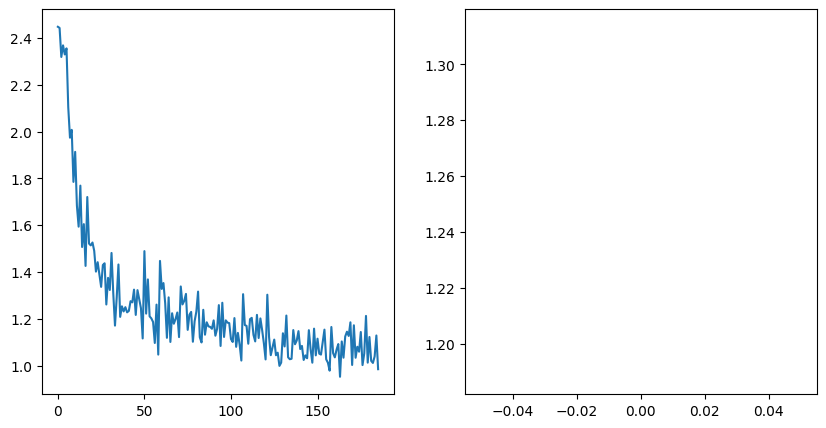

In [35]:
batch_size = 16

epochs = 1
lr = 0.01

dataset = CityscapeDataset(train_dir, label_model)
data_loader = DataLoader(dataset, batch_size = batch_size)
model = UNet(num_classes = num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = lr)

step_losses = []
epoch_losses = []

for epoch in tqdm(range(epochs)):
  epoch_loss = 0
  for X,Y in tqdm(data_loader, total=len(data_loader), leave = False):
    X, Y = X.to(device), Y.to(device)
    optimizer.zero_grad()
    Y_pred = model(X)
    loss = criterion(Y_pred, Y)
    loss.backward()
    optimizer.step()
    epoch_loss += loss.item()
    step_losses.append(loss.item())
  epoch_losses.append(epoch_loss/len(data_loader))

fig, axes = plt.subplots(1,2, figsize=(10,5))
axes[0].plot(step_losses)
axes[1].plot(epoch_losses)

model_name = "part4.pt"
torch.save(model.state_dict(), model_name)

In [36]:
test_batch_size = 10
dataset = CityscapeDataset(val_dir, label_model)
data_loader = DataLoader(dataset, batch_size=test_batch_size)

for X, Y in data_loader:
    X = X.to(device)
    Y = Y.to(device)
    Y_pred = model(X)
    print(Y_pred.shape)
    Y_pred = torch.argmax(Y_pred, dim=1)
    print(Y_pred.shape)
    break

torch.Size([10, 10, 256, 256])
torch.Size([10, 256, 256])


In [37]:
inverse_transform = transforms.Compose([
    transforms.Normalize((-0.485/0.229, -0.456/0.224, -0.406/0.225), (1/0.229, 1/0.224, 1/0.225))
])

iou_scores = []
for i in range(test_batch_size):
    
    landscape = inverse_transform(X[i]).permute(1, 2, 0).cpu().detach().numpy()
    label_class = Y[i].cpu().detach().numpy()
    label_class_predicted = Y_pred[i].cpu().detach().numpy()
    
    # IOU score for multiclass classification
    class_iou = []
    for j in range(num_classes):
        intersection = np.logical_and(label_class == j, label_class_predicted == j)
        union = np.logical_or(label_class == j, label_class_predicted == j)
        if (np.sum(union) == 0):
            continue
        iou = np.sum(intersection) / np.sum(union)
        class_iou.append(iou)
    mean_iou = np.mean(class_iou)
    iou_scores.append(mean_iou)
print(sum(iou_scores) / len(iou_scores))

iou_scores

0.1725380372226239


[0.15910291773255225,
 0.16635435713793945,
 0.1967896385854349,
 0.20190571181512396,
 0.22640533355012846,
 0.19270882386537086,
 0.09280915817272085,
 0.12270041398298773,
 0.19283129643453933,
 0.17377272094944124]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/186 [00:00<?, ?it/s]

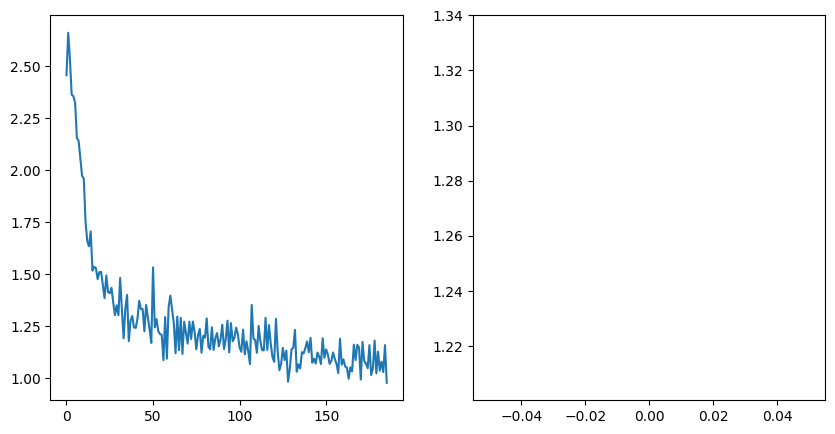

In [38]:
batch_size = 16

epochs = 1
lr = 0.01

dataset = CityscapeDataset(train_dir, label_model)
data_loader = DataLoader(dataset, batch_size = batch_size)
model = UNet(num_classes = num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = lr)

step_losses = []
epoch_losses = []

for epoch in tqdm(range(epochs)):
  epoch_loss = 0
  for X,Y in tqdm(data_loader, total=len(data_loader), leave = False):
    X, Y = X.to(device), Y.to(device)
    optimizer.zero_grad()
    Y_pred = model(X)
    loss = criterion(Y_pred, Y)
    loss.backward()
    optimizer.step()
    epoch_loss += loss.item()
    step_losses.append(loss.item())
  epoch_losses.append(epoch_loss/len(data_loader))

fig, axes = plt.subplots(1,2, figsize=(10,5))
axes[0].plot(step_losses)
axes[1].plot(epoch_losses)

model_name = "part4_without_skip.pt"
torch.save(model.state_dict(), model_name)

In [39]:
test_batch_size = 10
dataset = CityscapeDataset(val_dir, label_model)
data_loader = DataLoader(dataset, batch_size=test_batch_size)

for X, Y in data_loader:
    X = X.to(device)
    Y = Y.to(device)
    Y_pred = model(X)
    print(Y_pred.shape)
    Y_pred = torch.argmax(Y_pred, dim=1)
    print(Y_pred.shape)
    break

torch.Size([10, 10, 256, 256])
torch.Size([10, 256, 256])


In [40]:
inverse_transform = transforms.Compose([
    transforms.Normalize((-0.485/0.229, -0.456/0.224, -0.406/0.225), (1/0.229, 1/0.224, 1/0.225))
])

iou_scores = []
for i in range(test_batch_size):
    
    landscape = inverse_transform(X[i]).permute(1, 2, 0).cpu().detach().numpy()
    label_class = Y[i].cpu().detach().numpy()
    label_class_predicted = Y_pred[i].cpu().detach().numpy()
    
    # IOU score for multiclass classification
    class_iou = []
    for j in range(num_classes):
        intersection = np.logical_and(label_class == j, label_class_predicted == j)
        union = np.logical_or(label_class == j, label_class_predicted == j)
        if (np.sum(union) == 0):
            continue
        iou = np.sum(intersection) / np.sum(union)
        class_iou.append(iou)
    mean_iou = np.mean(class_iou)
    iou_scores.append(mean_iou)
print(sum(iou_scores) / len(iou_scores))

iou_scores

0.17619717503548277


[0.1345629421317754,
 0.18095872888500938,
 0.20908138114910768,
 0.2199858828018672,
 0.23443759698178615,
 0.20599930773937958,
 0.09401109052432832,
 0.11363410179482931,
 0.2009630902303881,
 0.1683376281163565]

This time, The mIoU values for both the models are distinguishable. The Mean IoU was 0.17619717503548277  before and now it got reduced to 0.1725380372226239. This drop can be observed from the removal of skip connections which lead to drop in the quality of reconstruction of images in the architecture. Earlier. since we were not computing IoU class-wise, we were only treating predictions in the binary masking fashion which is not the correct way for multi-class classification, but evaluation via taking mean over all classes in multi-class classification yields us the true values.


1. **Preserving Spatial Information**:
Skip-Connections allow combining fine-grained details with higher-level features. Better spatial information preservation leads to improved segmentation accuracy.

2. **Feature Reuse**:
Skip connections enable reuse of features learned at different levels. This helps segment objects of various sizes and shapes. The model can better adapt to complex data by incorporating diverse features. Without skip connections, the model might be limited in capturing object characteristics.

3. **Contextual Information**:
Skip connections provide contextual information by combining multi-resolution features. Contextual information allows assigning correct class labels to each pixel. Without skip connections, the model might struggle with global context, leading to errors.

***Links to all the Pretrained Models:***

1. U-Net Architecture With Skip Connections - [Link](https://iiitaphyd-my.sharepoint.com/:u:/g/personal/pranav_g_students_iiit_ac_in/EciWz0tiNbBCigqaKCKnyIoBLLATAU5pJ6G-9yJRc7C3Mg?e=AYaWHQ)

2. U-Net Architecture Without Skip Connections - [Link](https://iiitaphyd-my.sharepoint.com/:u:/g/personal/pranav_g_students_iiit_ac_in/Eednf5lA3kRKv1RWNnLco1EB1QirTMdEYaU0jrdjpKpNzA?e=h2ErHV)


3. Part 4 (with Skip Connections) - [Link](https://iiitaphyd-my.sharepoint.com/:u:/g/personal/pranav_g_students_iiit_ac_in/Ef1ofb5Mi3VKhrYGKCZ0UQoBDHJ4g05kcDzGSno-gFlP5g?e=n1dc2l)

4. Part 4 (without Skip Connections) - [Link](https://iiitaphyd-my.sharepoint.com/:u:/g/personal/pranav_g_students_iiit_ac_in/EXJ_Y8l3MM9Nms8u3-IBXlwBaNt8pBN4Vw2E_9oAPrKQ-g?e=6k3Z2l)

# 2. Contrastive Language-Image Pretraining (CLIP)

## 2.1 Setup models

In [41]:
!pip3 install torchsummary

In [42]:
!pip3 install git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-fd5bawtr
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-fd5bawtr
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.0/43.0 kB 1.9 MB/s eta 0:00:00
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369490 sha256=786102e44ef37a2ef289fc407a063bcf0f898641bb5a4c41382d363dfb5f1282
  Stored in directory: /tmp/pip-ephem-wheel-cache-yru7vln9/wheels/da/2b/4c/d6691fa9597aac8bb85d2ac13b112deb897d5b50f5ad9a37e4
Successfully built clip


In [43]:
import numpy as np
import torch
import torchvision
import torchsummary as summary
import clip
import cv2

In [44]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [45]:
classes_dict = {}
idx = 0
with open ("/kaggle/input/computer-vision-assignment-4-clip-dataset/imagenet_classes.txt", "r") as f:
    x = f.read()
    y = x.split("\n")
    for i in range(len(y)):
        classes_dict[idx] = y[i]
        idx += 1

In [67]:
model = torch.hub.load("pytorch/vision", "resnet50", weights="IMAGENET1K_V2").to(device)

Using cache found in /root/.cache/torch/hub/pytorch_vision_main


In [68]:
summary.summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [60]:
model1, preprocess = clip.load("RN50", device=device)

for name, param in model1.named_parameters():
    precision = param.dtype
    print(f"Layer: {name}, precision: {precision}")
summary.summary(model1.visual, (3, 224, 224))

Layer: positional_embedding, precision: torch.float32
Layer: text_projection, precision: torch.float16
Layer: logit_scale, precision: torch.float32
Layer: visual.conv1.weight, precision: torch.float16
Layer: visual.bn1.weight, precision: torch.float32
Layer: visual.bn1.bias, precision: torch.float32
Layer: visual.conv2.weight, precision: torch.float16
Layer: visual.bn2.weight, precision: torch.float32
Layer: visual.bn2.bias, precision: torch.float32
Layer: visual.conv3.weight, precision: torch.float16
Layer: visual.bn3.weight, precision: torch.float32
Layer: visual.bn3.bias, precision: torch.float32
Layer: visual.layer1.0.conv1.weight, precision: torch.float16
Layer: visual.layer1.0.bn1.weight, precision: torch.float32
Layer: visual.layer1.0.bn1.bias, precision: torch.float32
Layer: visual.layer1.0.conv2.weight, precision: torch.float16
Layer: visual.layer1.0.bn2.weight, precision: torch.float32
Layer: visual.layer1.0.bn2.bias, precision: torch.float32
Layer: visual.layer1.0.conv3.weig

1. Conv, bn, and relu are the three layers that the CLIP basic RN50 backbone uses before feeding it into layer blocks of resnet50. It also seems that there are differences in the architecture of the (Conv, bn, relu). It only uses one layer (Conv, bn, relu) before feeding into layers 1, 2, 3, and 4 of the ResNet50 (IMAGENET).
2. It is important to keep in mind that ResNet50, which is based on CLIP, uses an attention module at the end of the design, which is a novel feature that ResNet 50 (IMAGENET) does not use.
3. It is important to note that the output of the clip-based RN50, following the attention pool module, was 1024 dim, while the original ResNet50 (IMAGENET) produced an output of 1000 dim.

## 2.2. Setup data

(i) Label Hierarchy: ImageNet organises its labels into a hierarchical framework. Labels are arranged into a tree-like structure, with parent nodes standing in for particular cases or subcategories and each node representing a category. The objects can be more precisely categorised thanks to this structure.

(ii) Synset: A synset, short for synonym set, in ImageNet is a collection of synonym words that stand in for an object class or a concept. Every synset is given a unique identification, and these synsets in ImageNet correlate to particular labels or categories. As an example, the synset "cat" might have labels such as "Siamese cat," "tabby cat," and so forth.

(iii) Grouping things based on Synsets and Issues: Oversimplifying the diversity within a category, grouping things based on synsets can occasionally cause issues with visual identification. For instance, the synset "dog" might contain dogs of different sizes, breeds, and stances. It might be difficult for a model trained on this synset to distinguish between several breeds or variants within the category.

(iv) Distinctions in Appearance Among Synsets:

Pose Variation: Different stances or orientations can be displayed by objects that belong to the same synset. For example, a synset titled "dogs" might have pictures of dogs in different poses, such sitting, standing, or lying down.
Appearance Variation: Colour, texture, and size are just a few examples of the variables that can cause noticeable changes in appearance amongst objects in the same synset. Images of roses, daisies, and tulips, for instance, might all be found in the synset for "flowers," despite their differing hues and petal forms.
Contextual Variation: Items within the same synset may manifest in various environments or settings. Images of vehicles on highways, in parking lots, and even in garages, for instance, might be included in the synset for the word "car". The surrounds and background might differ greatly, which can have an impact on visual appearance of the object.

## 2.3 Setup zero-shot CLIP

In [61]:
from PIL import Image

def similarity(model1, image):
    image_np = cv2.imread(image)
    image = Image.fromarray(image_np.astype(np.uint8)).convert('RGB')  # Convert to RGB mode if necessary
    image_input = preprocess(image).unsqueeze(0).to(device)
    text_inputs = torch.cat([clip.tokenize(f"a photo of a {classes_dict[c]}") for c in classes_dict]).to(device)

    with torch.no_grad():
        image_features = model1.encode_image(image_input)
        text_features = model1.encode_text(text_inputs)

    image_features /= image_features.norm(dim=-1, keepdim=True)
    text_features /= text_features.norm(dim=-1, keepdim=True)
    similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)
    values, indices = similarity[0].topk(5)
    print("\nTop predictions:\n")
    values_np = values.detach().cpu().numpy()
    indices_np = indices.detach().cpu().numpy()
    for value, index in zip(values_np, indices_np):
        print(f"{classes_dict[index]:>16s}: {100 * value.item():.2f}%")
    return

In [62]:
similarity(model1, '/kaggle/input/computer-vision-assignment-4-clip-dataset/tiger.jpeg')
similarity(model1, '/kaggle/input/computer-vision-assignment-4-clip-dataset/dog.jpeg')
similarity(model1, '/kaggle/input/computer-vision-assignment-4-clip-dataset/chair.jpeg')
similarity(model1, '/kaggle/input/computer-vision-assignment-4-clip-dataset/bird.jpeg')
similarity(model1, '/kaggle/input/computer-vision-assignment-4-clip-dataset/lion.jpeg')


Top predictions:

tiger, Panthera tigris: 46.12%
           zebra: 30.25%
       tiger cat: 17.24%
        Leonberg: 2.64%
wild boar, boar, Sus scrofa: 0.22%

Top predictions:

  English setter: 33.79%
  Great Pyrenees: 26.73%
Old English sheepdog, bobtail: 6.76%
Labrador retriever: 6.55%
clumber, clumber spaniel: 4.29%

Top predictions:

            desk: 81.93%
dining table, board: 5.94%
file, file cabinet, filing cabinet: 2.40%
   folding chair: 0.97%
pedestal, plinth, footstall: 0.49%

Top predictions:

         jacamar: 72.75%
       bee eater: 8.17%
        hornbill: 4.44%
little blue heron, Egretta caerulea: 1.44%
           macaw: 0.98%

Top predictions:

lion, king of beasts, Panthera leo: 91.55%
cougar, puma, catamount, mountain lion, painter, panther, Felis concolor: 2.72%
snow leopard, ounce, Panthera uncia: 1.96%
        Leonberg: 0.90%
     Persian cat: 0.25%


## 2.4 CLIP vs ImageNet Pretraining

CLIP's multimodal approach enables it to understand concepts beyond visual appearance. These images might contain textual descriptions or contextual cues that CLIP can leverage for accurate classification, whereas ImageNet pretrained ResNet50 relies solely on visual features.

In [69]:
import os

def list_files(directory):
    file_paths = []
    for root, _, files in os.walk(directory):
        for file in files:
            file_paths.append(os.path.join(root, file))
    return file_paths

directory_path = '/kaggle/input/computer-vision-assignment-4-clip-dataset/Images'
file_paths = list_files(directory_path)
print(file_paths)

['/kaggle/input/computer-vision-assignment-4-clip-dataset/Images/sushi_3.jpeg', '/kaggle/input/computer-vision-assignment-4-clip-dataset/Images/cake_2.jpg', '/kaggle/input/computer-vision-assignment-4-clip-dataset/Images/beach_1.jpg', '/kaggle/input/computer-vision-assignment-4-clip-dataset/Images/firework.jpeg', '/kaggle/input/computer-vision-assignment-4-clip-dataset/Images/elephant_3.jpg', '/kaggle/input/computer-vision-assignment-4-clip-dataset/Images/clock_2.jpg', '/kaggle/input/computer-vision-assignment-4-clip-dataset/Images/banana_2.jpg', '/kaggle/input/computer-vision-assignment-4-clip-dataset/Images/sunglasses_1.jpg', '/kaggle/input/computer-vision-assignment-4-clip-dataset/Images/penguin_1.jpg', '/kaggle/input/computer-vision-assignment-4-clip-dataset/Images/helicopter_1.jpg', '/kaggle/input/computer-vision-assignment-4-clip-dataset/Images/microscope_1.jpeg', '/kaggle/input/computer-vision-assignment-4-clip-dataset/Images/chessboard_2.png', '/kaggle/input/computer-vision-ass

In [73]:
import torch
import torchvision.transforms as transforms
from PIL import Image

model1.eval()
# Define preprocessing transformations
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

images = file_paths
for img in images:
    print(f"{img = }")
    input_image = Image.open(img)
    if input_image.mode != 'RGB':
        input_image = input_image.convert('RGB')
    input_tensor = preprocess(input_image)
    input_batch = input_tensor.unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(input_batch)
        _, predicted = torch.max(output, 1)
        predicted_label = classes_dict[predicted.item()]
        print("Predicted Label for ImageNet pretrained RN50:", predicted_label)
        print("Predictions for CLIP", end='')
        similarity(model1, img)
        print("\n\n\n")

img = '/kaggle/input/computer-vision-assignment-4-clip-dataset/Images/sushi_3.jpeg'
Predicted Label for ImageNet pretrained RN50: hammer
Predictions for CLIP
Top predictions:

bonnet, poke bonnet: 7.64%
            wing: 6.04%
pick, plectrum, plectron: 5.42%
           plate: 4.78%
          abacus: 3.96%




img = '/kaggle/input/computer-vision-assignment-4-clip-dataset/Images/cake_2.jpg'
Predicted Label for ImageNet pretrained RN50: sunglass
Predictions for CLIP
Top predictions:

        bassinet: 16.94%
       overskirt: 15.43%
            gown: 10.61%
groom, bridegroom: 9.81%
      shower cap: 4.56%




img = '/kaggle/input/computer-vision-assignment-4-clip-dataset/Images/beach_1.jpg'
Predicted Label for ImageNet pretrained RN50: pelican
Predictions for CLIP
Top predictions:

sandbar, sand bar: 13.13%
     water snake: 4.47%
       sea snake: 3.65%
balance beam, beam: 3.48%
iron, smoothing iron: 3.02%




img = '/kaggle/input/computer-vision-assignment-4-clip-dataset/Images/firewor

Based upon the Outputs obtained, we conclude that the following are the results:

**1. Clock 4: Works with Resnet Encoder but fails with CLIP.**

**2. beach 1: Works with CLIP Encoder but fails with Resnet.**

**3. helicopter: Works with Resnet Encoder but fails with CLIP.**

**4. penguin1: Works with Resnet Encoder but fails with CLIP.**

**5. cake 2: Works with Resnet Encoder but fails with CLIP.**

**6. sunflower1: Works with CLIP Encoder but fails with Resnet.**

**7. banana1: Works with Resnet Encoder but fails with CLIP.**

## 2.5 FP16 vs FP32

### Part 1: Convert the RN50 CLIP image encoder model to fp16.

In [65]:
model1, preprocess = clip.load("RN50", device=device)
model1 = model1.to(device)

for name, param in clip_model.named_parameters():
    precision = param.dtype
    print(f"Layer: {name}, precision: {precision}")

Layer: positional_embedding, precision: torch.float16
Layer: text_projection, precision: torch.float16
Layer: logit_scale, precision: torch.float16
Layer: visual.conv1.weight, precision: torch.float16
Layer: visual.bn1.weight, precision: torch.float16
Layer: visual.bn1.bias, precision: torch.float16
Layer: visual.conv2.weight, precision: torch.float16
Layer: visual.bn2.weight, precision: torch.float16
Layer: visual.bn2.bias, precision: torch.float16
Layer: visual.conv3.weight, precision: torch.float16
Layer: visual.bn3.weight, precision: torch.float16
Layer: visual.bn3.bias, precision: torch.float16
Layer: visual.layer1.0.conv1.weight, precision: torch.float16
Layer: visual.layer1.0.bn1.weight, precision: torch.float16
Layer: visual.layer1.0.bn1.bias, precision: torch.float16
Layer: visual.layer1.0.conv2.weight, precision: torch.float16
Layer: visual.layer1.0.bn2.weight, precision: torch.float16
Layer: visual.layer1.0.bn2.bias, precision: torch.float16
Layer: visual.layer1.0.conv3.weig

In [66]:
model2, preprocess = clip.load("RN50", device=device)

model2 = model2.half()
model2 = model2.to(device)

for name, param in clip_model.named_parameters():
    precision = param.dtype
    print(f"Layer: {name}, precision: {precision}")

Layer: positional_embedding, precision: torch.float16
Layer: text_projection, precision: torch.float16
Layer: logit_scale, precision: torch.float16
Layer: visual.conv1.weight, precision: torch.float16
Layer: visual.bn1.weight, precision: torch.float16
Layer: visual.bn1.bias, precision: torch.float16
Layer: visual.conv2.weight, precision: torch.float16
Layer: visual.bn2.weight, precision: torch.float16
Layer: visual.bn2.bias, precision: torch.float16
Layer: visual.conv3.weight, precision: torch.float16
Layer: visual.bn3.weight, precision: torch.float16
Layer: visual.bn3.bias, precision: torch.float16
Layer: visual.layer1.0.conv1.weight, precision: torch.float16
Layer: visual.layer1.0.bn1.weight, precision: torch.float16
Layer: visual.layer1.0.bn1.bias, precision: torch.float16
Layer: visual.layer1.0.conv2.weight, precision: torch.float16
Layer: visual.layer1.0.bn2.weight, precision: torch.float16
Layer: visual.layer1.0.bn2.bias, precision: torch.float16
Layer: visual.layer1.0.conv3.weig

#### ***We can observe that the original model has both layers simlutaneously. When we do half, then we have only the float16 dtype left.***

In [62]:
from time import perf_counter
from PIL import Image


def encode_image(model, image):
    image_np = cv2.imread(image)
    image = Image.fromarray(image_np.astype(np.uint8)).convert('RGB')  # Convert to RGB mode if necessary
    image_input = preprocess(image).unsqueeze(0).to(device)
    text_inputs = torch.cat([clip.tokenize(f"a photo of a {classes_dict[c]}") for c in classes_dict]).to(device)

    with torch.no_grad():
        image_features = model.encode_image(image_input)
        text_features = model.encode_text(text_inputs)
    return image_features, text_features


def measure_inference_time(model, image, num_runs=100):
    times = []
    for _ in range(num_runs):
        start_time = perf_counter()
        encode_image(model, image)
        end_time = perf_counter()
        times.append(end_time - start_time)
    mean_time = sum(times) / len(times)
    std_dev = torch.std(torch.tensor(times))
    return mean_time, std_dev


def compute_class_probabilites(model, image):
    image_features, text_features = encode_image(model, image)
    image_features /= image_features.norm(dim=-1, keepdim=True)
    text_features /= text_features.norm(dim=-1, keepdim=True)
    similarity = (100.0 * image_features @ text_features.T).float().softmax(dim=-1)
    values, indices = similarity[0].topk(5)
    print("\nTop predictions:\n")
    values_np = values.detach().cpu().numpy()
    indices_np = indices.detach().cpu().numpy()
    for value, index in zip(values_np, indices_np):
        print(f"{classes_dict[index]:>16s}: {100 * value.item():.2f}%")
    return

(wall-clock) time required to encode an image

In [69]:
images = ['/kaggle/input/computer-vision-assignment-4-clip-dataset/tiger.jpeg', '/kaggle/input/computer-vision-assignment-4-clip-dataset/chair.jpeg', '/kaggle/input/computer-vision-assignment-4-clip-dataset/dog.jpeg', '/kaggle/input/computer-vision-assignment-4-clip-dataset/bird.jpeg', '/kaggle/input/computer-vision-assignment-4-clip-dataset/lion.jpeg']

# fp32 model evaluation
fp32_mean_time, fp32_std_dev = measure_inference_time(model1, '/kaggle/input/computer-vision-assignment-4-clip-dataset/tiger.jpeg')
print(f"FP32 Mean Inference Time: {fp32_mean_time:.4f}s, Standard Deviation: {fp32_std_dev:.4f}s")

FP32 Mean Inference Time: 1.2562s, Standard Deviation: 0.0090s


In [73]:
# fp16 model evaluation
with torch.autocast(device_type="cuda", dtype=torch.float16):
    model.eval()
    fp16_mean_time, fp16_std_dev = measure_inference_time(model2, '/kaggle/input/computer-vision-assignment-4-clip-dataset/tiger.jpeg')

    print(f"FP16 Mean Inference Time: {fp16_mean_time:.4f}s, Standard Deviation: {fp16_std_dev:.4f}s")
    print(f"Speedup: {(fp32_mean_time - fp16_mean_time) / fp32_mean_time:.2f}x")

FP16 Mean Inference Time: 1.2558s, Standard Deviation: 0.0158s
Speedup: 0.00x


**We observe that no speedup is obtained, which is quite non-intuitive, since calculations in float-16 should require lesser time as compared to float-32, but we also need to take into account the fact that a large fraction of time is devoted to quantization. We also need to translate inputs from fp32 to fp16 datatype, which effectively covers up the speedup that we obtain.**

### 2.5 (Part 2) Differences between FP16 and FP32 outputs

In [75]:
with torch.autocast(device_type="cuda", dtype=torch.float16):
    model2.eval()
    for img in images:
        compute_class_probabilites(model2, img)


Top predictions:

tiger, Panthera tigris: 44.87%
           zebra: 31.33%
       tiger cat: 17.30%
        Leonberg: 2.69%
wild boar, boar, Sus scrofa: 0.22%

Top predictions:

            desk: 82.02%
dining table, board: 5.85%
file, file cabinet, filing cabinet: 2.36%
   folding chair: 0.97%
     photocopier: 0.49%

Top predictions:

  English setter: 34.18%
  Great Pyrenees: 26.21%
Old English sheepdog, bobtail: 6.84%
Labrador retriever: 6.52%
clumber, clumber spaniel: 4.41%

Top predictions:

         jacamar: 73.18%
       bee eater: 8.21%
        hornbill: 4.26%
little blue heron, Egretta caerulea: 1.38%
           macaw: 0.97%

Top predictions:

lion, king of beasts, Panthera leo: 91.55%
cougar, puma, catamount, mountain lion, painter, panther, Felis concolor: 2.76%
snow leopard, ounce, Panthera uncia: 1.93%
        Leonberg: 0.90%
     Persian cat: 0.26%


In [76]:
model1.eval()
for img in images:
    compute_class_probabilites(model1, img)


Top predictions:

tiger, Panthera tigris: 46.12%
           zebra: 30.25%
       tiger cat: 17.23%
        Leonberg: 2.64%
wild boar, boar, Sus scrofa: 0.22%

Top predictions:

            desk: 81.94%
dining table, board: 5.94%
file, file cabinet, filing cabinet: 2.40%
   folding chair: 0.97%
pedestal, plinth, footstall: 0.49%

Top predictions:

  English setter: 33.78%
  Great Pyrenees: 26.72%
Old English sheepdog, bobtail: 6.76%
Labrador retriever: 6.55%
clumber, clumber spaniel: 4.29%

Top predictions:

         jacamar: 72.77%
       bee eater: 8.16%
        hornbill: 4.44%
little blue heron, Egretta caerulea: 1.44%
           macaw: 0.98%

Top predictions:

lion, king of beasts, Panthera leo: 91.55%
cougar, puma, catamount, mountain lion, painter, panther, Felis concolor: 2.72%
snow leopard, ounce, Panthera uncia: 1.96%
        Leonberg: 0.90%
     Persian cat: 0.25%


**We observe that not much difference in outputs is obtained by quantization. This leads us to the conclusion that CLIP model is able to account for the Quantization part, and does not lead to generation of completely different outputs with changes in datatype of the model.**

### 2.5 (Part 3): Differences in Memory Usage of the Models

While small CLIP models such as a ResNet-50 and ResNet-101 outperform other ResNets trained on ImageNet-1K (BiT-S and the originals), they underperform ResNets trained on ImageNet-21K (BiTM). These small CLIP models also underperform models in the EfficientNet family with similar compute requirements. However, models trained with CLIP scale very well and the largest model we trained (ResNet-50x64) slightly outperforms the best performing existing model (a Noisy Student EfficientNet-L2) on both overall score and compute efficiency. We also find that CLIP vision transformers are about 3x more compute efficient than CLIP ResNets, which allows us to reach higher overall performance within our compute budget.

In [86]:
# for the fp16 model
image_path = "/kaggle/input/computer-vision-assignment-4-clip-dataset/tiger.jpeg"
image = preprocess(Image.open(image_path)).unsqueeze(0).to(device)
image = image.half()

model_fp16, preprocess = clip.load("RN50", device=device)
model_fp16 = model_fp16.half()
model_fp16 = model_fp16.to(device)

with torch.cuda.amp.autocast(enabled=True):
    torch.cuda.memory._record_memory_history(enabled=None)
    start = torch.cuda.memory_summary()
    model_fp16.encode_image(image)
    print(f"Memory usage with FP16 input: {torch.cuda.memory_allocated(device)} bytes")
    end = torch.cuda.memory_summary()
    torch.cuda.memory._record_memory_history(enabled=None)
    print(start)
    print(end)

Memory usage with FP16 input: 1577331712 bytes
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |   1504 MiB |   7161 MiB |  25136 GiB |  25135 GiB |
|       from large pool |   1379 MiB |   7153 MiB |  25093 GiB |  25092 GiB |
|       from small pool |    124 MiB |    162 MiB |     42 GiB |     42 GiB |
|---------------------------------------------------------------------------|
| Active memory         |   1504 MiB |   7161 MiB |  25136 GiB |  25135 GiB |
|       from larg

/tmp/ipykernel_30/1979289074.py:10: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):


In [87]:
# for the fp32 model
image_path = "/kaggle/input/computer-vision-assignment-4-clip-dataset/tiger.jpeg"
image = preprocess(Image.open(image_path)).unsqueeze(0).to(device)

clip_model, preprocess = clip.load("RN50", device=device)
clip_model = clip_model.to(device)

with torch.cuda.amp.autocast(enabled=True):
    torch.cuda.memory._record_memory_history(enabled=None)
    start = torch.cuda.memory_summary()
    clip_model.encode_image(image)
    print(f"Memory usage with FP32 input: {torch.cuda.memory_allocated(device)} bytes")
    end = torch.cuda.memory_summary()
    torch.cuda.memory._record_memory_history(enabled=None)
    print(start)
    print(end)

Memory usage with FP32 input: 1834843136 bytes
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |   1749 MiB |   7161 MiB |  25137 GiB |  25135 GiB |
|       from large pool |   1606 MiB |   7153 MiB |  25094 GiB |  25092 GiB |
|       from small pool |    143 MiB |    162 MiB |     42 GiB |     42 GiB |
|---------------------------------------------------------------------------|
| Active memory         |   1749 MiB |   7161 MiB |  25137 GiB |  25135 GiB |
|       from larg

/tmp/ipykernel_30/3677084756.py:8: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):


**Comparison**: Memory taken by fp32 Model is 1834843136 bytes while on the other hand fp16 uses 1577331712 bytes. We can see that because of Quantization Phenomenon, fp32 uses more memory than fp16 model. So, we conclude the fact that Memory Footprint is indeed reduced in the case of fp16 Quantized CLIP Model.